In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from XVA import *
from XVAFBSNNs import *

In [3]:
from FBSNNs import *
from ForwardContracts import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 200  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [21] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
model.load_model("models/Forward1D2.pth")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 200  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D+1] + 2 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
xvamodel = XVA(Xi, T, M, N, D, Mm, layers, mode, activation, model)

n_iter = 2 * 10**3
lr = 1e-3

In [17]:
n_iter = 11 * 10**2
lr = 1e-5

In [7]:
tot = time.time()
print(xvamodel.device)
graph = xvamodel.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 6.158e+00, Y0: 0.247, Time: 0.58, Learning Rate: 1.000e-03
It: 100, Loss: 4.275e-03, Y0: 0.018, Time: 15.61, Learning Rate: 1.000e-03
It: 200, Loss: 1.182e-03, Y0: 0.001, Time: 19.60, Learning Rate: 1.000e-03
It: 300, Loss: 9.302e-04, Y0: 0.000, Time: 21.29, Learning Rate: 1.000e-03
It: 400, Loss: 6.996e-04, Y0: 0.000, Time: 31.28, Learning Rate: 1.000e-03
It: 500, Loss: 5.064e-04, Y0: 0.000, Time: 17.88, Learning Rate: 1.000e-03
It: 600, Loss: 3.559e-04, Y0: 0.000, Time: 15.69, Learning Rate: 1.000e-03
It: 700, Loss: 2.457e-04, Y0: 0.000, Time: 15.39, Learning Rate: 1.000e-03
It: 800, Loss: 1.696e-04, Y0: 0.000, Time: 15.64, Learning Rate: 1.000e-03
It: 900, Loss: 1.199e-04, Y0: 0.000, Time: 15.51, Learning Rate: 1.000e-03
It: 1000, Loss: 8.905e-05, Y0: 0.000, Time: 19.40, Learning Rate: 1.000e-03
It: 1100, Loss: 7.093e-05, Y0: 0.000, Time: 18.24, Learning Rate: 1.000e-03
It: 1200, Loss: 6.084e-05, Y0: 0.000, Time: 34.23, Learning Rate: 1.000e-03
It: 1300, Loss: 5.

In [18]:
tot = time.time()
print(xvamodel.device)
graph = xvamodel.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 1900, Loss: 5.046e-05, Y0: 0.000, Time: 0.16, Learning Rate: 1.000e-05
It: 2000, Loss: 5.045e-05, Y0: 0.000, Time: 15.97, Learning Rate: 1.000e-05
It: 2100, Loss: 5.033e-05, Y0: 0.000, Time: 15.69, Learning Rate: 1.000e-05
It: 2200, Loss: 5.031e-05, Y0: 0.000, Time: 20.32, Learning Rate: 1.000e-05
It: 2300, Loss: 5.029e-05, Y0: 0.000, Time: 23.51, Learning Rate: 1.000e-05
It: 2400, Loss: 5.026e-05, Y0: 0.000, Time: 27.40, Learning Rate: 1.000e-05
It: 2500, Loss: 5.023e-05, Y0: 0.000, Time: 17.28, Learning Rate: 1.000e-05
It: 2600, Loss: 5.019e-05, Y0: 0.000, Time: 15.86, Learning Rate: 1.000e-05
It: 2700, Loss: 5.016e-05, Y0: 0.000, Time: 15.84, Learning Rate: 1.000e-05
It: 2800, Loss: 5.012e-05, Y0: 0.000, Time: 16.02, Learning Rate: 1.000e-05
It: 2900, Loss: 5.008e-05, Y0: 0.000, Time: 16.03, Learning Rate: 1.000e-05
total time: 204.64258885383606 s


In [7]:
xvamodel.load_model("models/1DForwardFVAXVAPaper.pth")

In [8]:
t_test, W_test, X_test, C_test = xvamodel.fetch_minibatch()
X_pred, Y_pred = xvamodel.predict(C_test, t_test, W_test, X_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i, X_test_i, C_test_i = xvamodel.fetch_minibatch()
    X_pred_i, Y_pred_i = xvamodel.predict(C_test_i, t_test_i, W_test_i, X_test_i)
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

In [9]:
X_pred.shape

(12800, 51, 1)

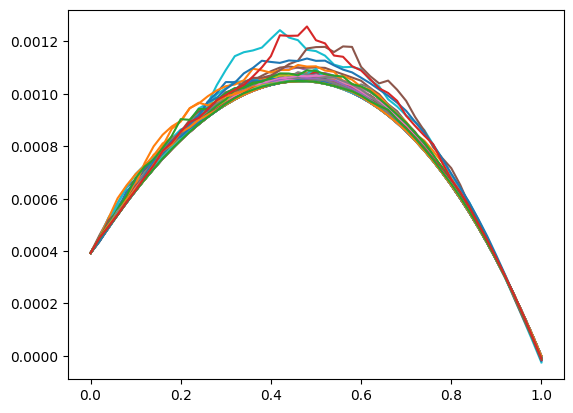

In [10]:
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')
plt.plot(t_test[1:64, :, 0].T, Y_pred[1:64, :, 0].T)
plt.show()

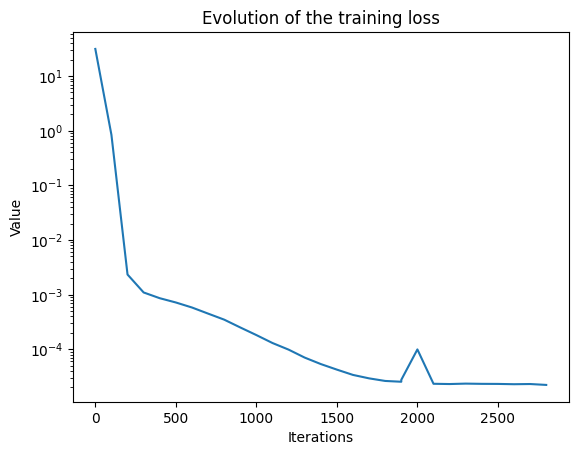

In [11]:
graph = xvamodel.iteration, xvamodel.training_loss
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.show()

In [12]:
Y_pred.shape

(12800, 51, 1)

In [13]:
Y_preds = Y_pred.reshape(12800, 51)

In [14]:
pred_fva = Y_preds[:,0][0] * 100

In [15]:
pred_fva

0.0392373651266098

In [16]:
time_stamp = t_test[0].reshape(51,)
time_stamp

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32)

In [17]:
x_init = 100
strike = 100
r = 0.02
sigma = 0.25
total_time = 1
r_f = 0.04

In [18]:
from scipy.stats import norm

rv = norm()    

d1 = np.array([(-r * s + np.log(x_init/strike) + (r+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamp[1:]])
d2 = np.array([d1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamp[1:])])

epe_exact = x_init*rv.cdf(d1) - strike*np.exp(-r)*rv.cdf(d2)
ene_exact = x_init*rv.cdf(-d1) - strike*np.exp(-r)*rv.cdf(-d2)

In [19]:
exactYhat = x_init - strike*np.exp(-r * total_time)
exactY = np.exp(-(r_f - r) * total_time)*x_init - strike*np.exp(-r_f * total_time)
exact_fva = exactYhat - exactY

In [20]:
exact_fva

0.039209253881267614

In [21]:
(pred_fva - exact_fva) ** 2 / exact_fva ** 2

5.140235477280962e-07

In [22]:
np.abs(pred_fva - exact_fva) / exact_fva * 100

0.0716954355400744

In [24]:
xvamodel.save_model("models/1DForwardFVAXVAPaper.pth")